# Overfitting on the IMDB movie reviews dataset

In this notebook we shall focus on overfitting, demonstrating the phenomenon and studying techniques to address it. The dataset we shall use is the IMDB movie reviews dataset, composed of 25,000 movies reviews, labeled by sentiment (positive/negative).

**Some techniques for preventing the Overfitting:**

To prevent overfitting, the best solution is to use more training data. When that is not a
viable possibility, you can try to use regularization techniques, constraining the quantity and quality of information stored by the model. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent ones, which have a better chance of generalizing well.



In [24]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np

Let us load the dataset. In keras, the dataset is preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. 

In [25]:
num_words = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=num_words)

Let us a look at the encoding of the first review.

In [26]:
print(x_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


This representation has a variable length dimension, that is not very stuitable for a neural network. 

Let us transform it into a multi_hot encoding of of dimension equal to num_words. In this representation, a word gets index 1 if it appears in the document. It is essentially a bag-of-words encoding.

In [27]:
def multi_hot_sequences(sequences, dimension): 
    """
    Args:
        - sequences: List of sequences to be converted to multi-hot representation.
        - dimension: Total number of unique words in the vocabulary.
    Outputs:
        - multi_hot: Returns the resulting multi-hot matrix.
    """
    
    multi_hot = np.zeros((len(sequences),dimension))
    for i in range(0,len(sequences)):
        multi_hot[i, sequences[i]] = 1
    return multi_hot

x_train = multi_hot_sequences(x_train, num_words)
x_test = multi_hot_sequences(x_test, num_words)

Let us have a look at the initial part of the encoding for the first review.

In [28]:
print(x_train[0,0:30])

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0.]


##### Model Creation
We now define our first model, that is just a concatenation of three dense layers.

In [29]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu')(seq)
x = Dense(16, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

base_model = Model(seq, x)

In [30]:
base_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,121 (129.38 KB)

 Trainable params: 33,121 (129.38 KB)

 Non-trainable params: 0 (0.00 B)

We compile the model using adam as optimizer, and binary crossentropy (log likelyhood) as loss function. The fit function returns a history of the training, that can be later inspected. In addition to the loss function, that is the canonical metric used for training, we also ask the model to keep trace of accuracy.

In [31]:
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
base_history = base_model.fit(
    x_train,
    y_train,
    epochs = 6,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 1
)

Epoch 1/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6337 - loss: 0.6327 - val_accuracy: 0.8008 - val_loss: 0.4363
Epoch 2/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8176 - loss: 0.4079 - val_accuracy: 0.8258 - val_loss: 0.3939
Epoch 3/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8341 - loss: 0.3790 - val_accuracy: 0.8324 - val_loss: 0.3827
Epoch 4/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8449 - loss: 0.3536 - val_accuracy: 0.8327 - val_loss: 0.3804
Epoch 5/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8452 - loss: 0.3545 - val_accuracy: 0.8328 - val_loss: 0.3799
Epoch 6/6
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8465 - loss: 0.3498 - val_accuracy: 0.8273 - val_loss: 0.3926


Let us see the keys available in our history.

In [33]:
print(base_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


The following function allows us to plot the results.

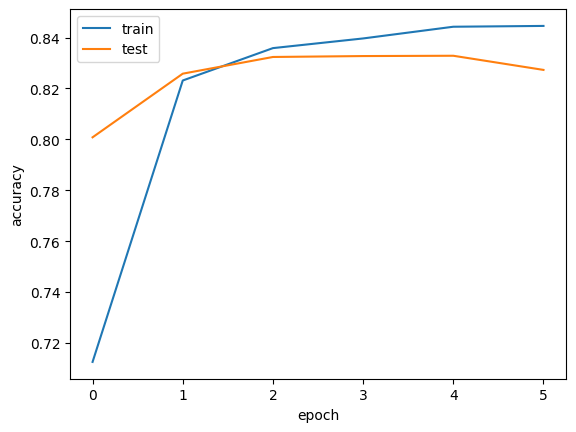

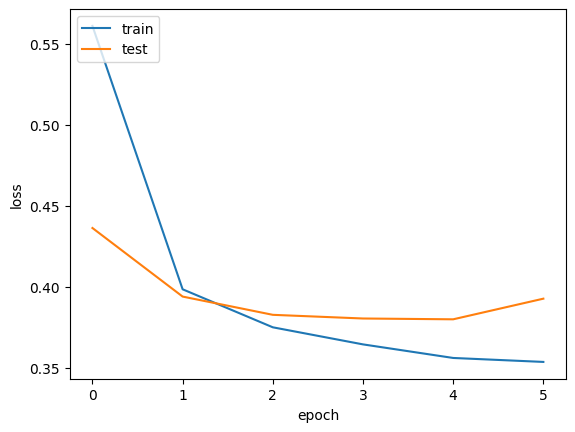

In [34]:
def plot_history(model_history, keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(base_history,['accuracy','val_accuracy'])
plot_history(base_history,['loss','val_loss'])


# Weight regularization technique
Weight regularization techniques in deep learning are methods used to prevent overfitting by adding penalties to the loss function associated with the model's weights. Overfitting occurs when a model learns to perform well on the training data but fails to generalize well to unseen data. Weight regularization techniques help mitigate overfitting by discouraging the learning of overly complex patterns in the data.

There are primarily two common types of weight regularization techniques:

1. **L1 Regularization**:
   - In L1 regularization, also known as Lasso regularization, a penalty term is added to the loss function proportional to the absolute value of the weights.
   - The regularization term is given by λ * ||w||_1, where λ is the regularization parameter and ||w||_1 represents the L1 norm of the weight vector.
   - This regularization encourages sparsity in the weight matrix, meaning that many of the weights are driven to zero, effectively removing irrelevant features from the model.

2. **L2 Regularization**:
   - L2 regularization, also called Ridge regularization, adds a penalty term to the loss function proportional to the squared magnitude of the weights.
   - The regularization term is given by λ/2 * ||w||^2_2, where λ is the regularization parameter and ||w||^2_2 represents the squared L2 norm of the weight vector.
   - This regularization penalizes large weights but does not enforce sparsity as aggressively as L1 regularization. It tends to distribute the weight values more evenly across all features.

Both L1 and L2 regularization are typically applied by adding the regularization term to the loss function during training. The choice between L1 and L2 regularization, as well as the value of the regularization parameter λ, is often determined through experimentation or by using techniques like cross-validation.

The regularization parameter controls the trade-off between fitting the training data well and keeping the model weights small. Higher values of λ lead to stronger regularization, which can help prevent overfitting but may also result in underfitting if set too high. Conversely, lower values of λ allow the model to fit the training data more closely but may lead to overfitting.

Generally, weight regularization techniques work in deep learning by penalizing large weights in the model, thereby reducing overfitting and improving generalization performance on unseen data.

Now we modify our base model adding regularizers. 

A common way to mitigate overfitting is to reduce the complexity of the network by forcing its weights to only take small values, making the distribution of weights more “**regular**”. This is called “**weight regularization**”, and it is done by adding to the loss function of the network an additional cost associated with having large weights. 

In [35]:
from keras import regularizers

seq = Input(shape=(num_words,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(seq)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dense(1, activation='sigmoid')(x)

l2reg_model = Model(seq, x)

In [36]:
l2reg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
l2reg_history = l2reg_model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 2
)

Epoch 1/5
49/49 - 2s - 36ms/step - accuracy: 0.7197 - loss: 1.0391 - val_accuracy: 0.8064 - val_loss: 0.7625
Epoch 2/5
49/49 - 0s - 8ms/step - accuracy: 0.8248 - loss: 0.6550 - val_accuracy: 0.8278 - val_loss: 0.5887
Epoch 3/5
49/49 - 1s - 12ms/step - accuracy: 0.8326 - loss: 0.5475 - val_accuracy: 0.8308 - val_loss: 0.5252
Epoch 4/5
49/49 - 0s - 6ms/step - accuracy: 0.8350 - loss: 0.5023 - val_accuracy: 0.8323 - val_loss: 0.4946
Epoch 5/5
49/49 - 0s - 6ms/step - accuracy: 0.8350 - loss: 0.4769 - val_accuracy: 0.8322 - val_loss: 0.4753


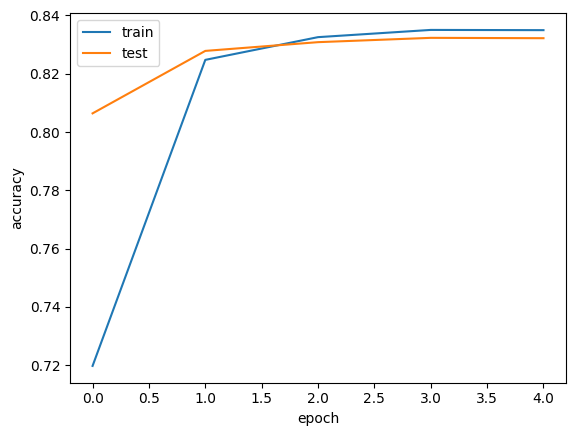

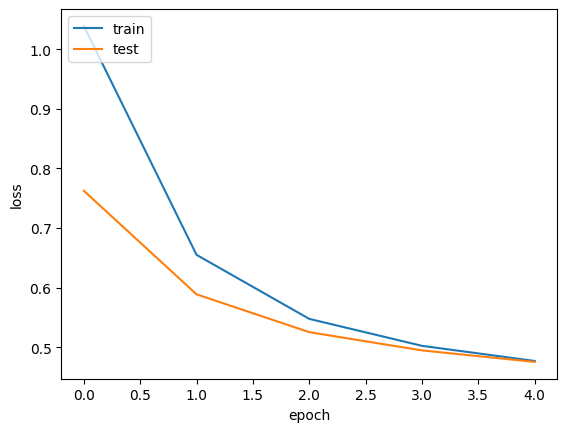

In [38]:
plot_history(l2reg_history,['accuracy','val_accuracy'])
plot_history(l2reg_history,['loss','val_loss'])

# Dropout

Dropout is a regularization technique used in deep learning to prevent overfitting by randomly "dropping out" (i.e., temporarily removing) units (both hidden and visible) during the training phase of a neural network. The idea behind dropout is to prevent complex co-adaptations of neurons by forcing them to learn more robust features on their own.

Here's how dropout works:

1. **Randomly "Dropout" Units**:
   - During each training iteration, dropout randomly selects a subset of neurons in a layer and sets their outputs to zero with a certain probability (usually around 0.2 to 0.5).
   - This process effectively removes these neurons temporarily from the network, making it smaller and less complex for that particular iteration.

2. **Training Phase**:
   - During training, dropout is applied to the input and hidden layers but not during the testing or inference phase.
   - This is because during testing, we want to use the entire network to make predictions without any dropout, as dropout is only used as a regularization technique to improve generalization during training.

3. **Improving Generalization**:
   - By randomly dropping out units during training, dropout prevents neurons from relying too heavily on the presence of other specific neurons.
   - This encourages each neuron to learn more useful and robust features independently, making the network more resilient to overfitting.

4. **Combating Co-adaptations**:
   - Dropout prevents co-adaptation of neurons, where certain neurons rely heavily on the presence of other specific neurons to perform well.
   - By randomly dropping out units, dropout ensures that no single neuron or group of neurons can dominate the training process.

5. **Ensemble Effect**:
   - Dropout can be seen as training an ensemble of multiple thinned networks, as each training iteration involves using a different subset of neurons.
   - At test time, the predictions of these different thinned networks are averaged, leading to a more robust prediction.

6. **Implementation**:
   - Dropout is typically implemented as a layer in modern deep learning frameworks such as TensorFlow or PyTorch.
   - It's seamlessly integrated into the network architecture and can be easily added between layers using Dropout layers provided by these frameworks.

Overall, dropout is a powerful and widely used regularization technique in deep learning that helps improve the generalization performance of neural networks by preventing overfitting and encouraging the learning of more robust features.

Dropout is an alternativeregularization techniques for neural networks. It consists of randomly “dropping out” (i.e. set to zero) a number of output features of the layer during training. 

At test time, no units are dropped out, but the layer’s output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In [39]:
from keras.layers import Dropout
from keras import optimizers

Let’s add a couple of dropout layers in our IMDB network and see how it performs.


In [40]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu')(seq)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

dropout_model = Model(seq, x)

In [41]:
dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
dropout_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,121 (129.38 KB)

 Trainable params: 33,121 (129.38 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
dropout_history = dropout_model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 1
)

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5177 - loss: 0.7061 - val_accuracy: 0.7470 - val_loss: 0.5999
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6745 - loss: 0.6030 - val_accuracy: 0.8042 - val_loss: 0.4561
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7672 - loss: 0.4992 - val_accuracy: 0.8220 - val_loss: 0.4073
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7976 - loss: 0.4534 - val_accuracy: 0.8272 - val_loss: 0.3893
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8169 - loss: 0.4190 - val_accuracy: 0.8313 - val_loss: 0.3826


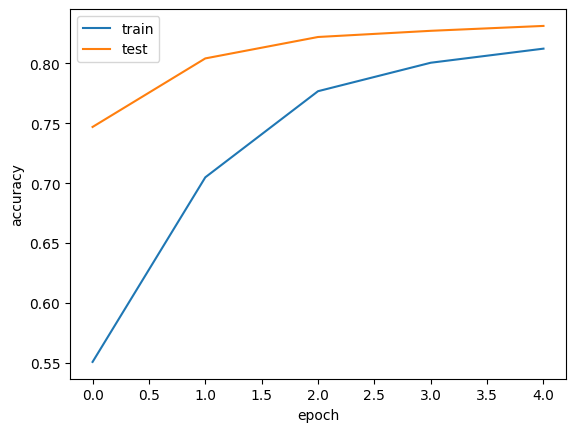

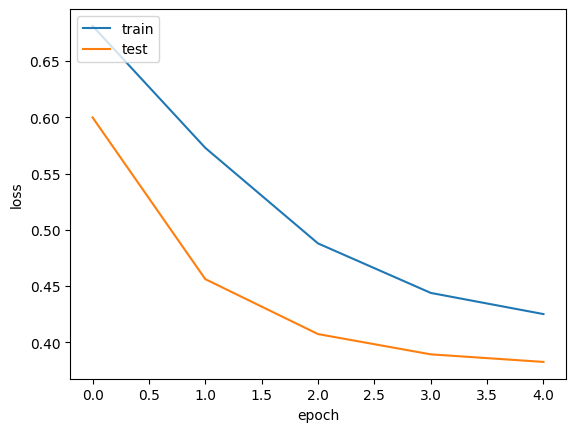

In [48]:
plot_history(dropout_history, ['accuracy','val_accuracy'])
plot_history(dropout_history, ['loss','val_loss'])

In [49]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(seq)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

mixed_model = Model(seq, x)

In [51]:
adam = optimizers.Adam(0.001)
mixed_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
mixed_history = mixed_model.fit(
    x_train,
    y_train,
    epochs = 5,
    batch_size = 512,
    validation_data = (x_test, y_test),
    verbose = 2
)

Epoch 1/5
49/49 - 2s - 48ms/step - accuracy: 0.5501 - loss: 1.1895 - val_accuracy: 0.7437 - val_loss: 0.9661
Epoch 2/5
49/49 - 1s - 20ms/step - accuracy: 0.6971 - loss: 0.8311 - val_accuracy: 0.8109 - val_loss: 0.6499
Epoch 3/5
49/49 - 0s - 7ms/step - accuracy: 0.7860 - loss: 0.6387 - val_accuracy: 0.8250 - val_loss: 0.5431
Epoch 4/5
49/49 - 0s - 8ms/step - accuracy: 0.8094 - loss: 0.5604 - val_accuracy: 0.8286 - val_loss: 0.4951
Epoch 5/5
49/49 - 1s - 12ms/step - accuracy: 0.8178 - loss: 0.5227 - val_accuracy: 0.8268 - val_loss: 0.4846


# Early stopping

Early stopping is a technique used in training machine learning models, including neural networks, to prevent overfitting and to find the optimal number of training iterations automatically. Instead of training the model for a fixed number of epochs, early stopping monitors the model's performance on a separate validation dataset during training and stops training when the performance on the validation set starts to degrade.

Here's how early stopping works:

1. **Training and Validation Sets**:
   - The dataset is typically split into three subsets: training, validation, and testing sets.
   - The training set is used to train the model, the validation set is used to monitor performance during training, and the testing set is used to evaluate the final performance of the trained model.

2. **Monitor Validation Performance**:
   - During training, the model's performance is evaluated on the validation set at regular intervals (e.g., after each epoch).
   - Metrics such as accuracy, loss, or any other relevant metric are computed on the validation set.

3. **Stop Criterion**:
   - Early stopping defines a stopping criterion based on the validation performance.
   - Common criteria include monitoring the validation loss or other metrics. For example, if the validation loss stops decreasing or starts to increase consistently for a certain number of epochs, early stopping is triggered.

4. **Stopping Training**:
   - When the stopping criterion is met, training is stopped early.
   - The model parameters at the point of early stopping are typically saved as the final model.

5. **Avoiding Overfitting**:
   - Early stopping helps prevent overfitting by stopping training before the model starts to memorize the training data too well.
   - By monitoring the validation performance, early stopping ensures that the model generalizes well to unseen data.

6. **Automatic Determination of Epochs**:
   - Instead of manually specifying the number of epochs, early stopping automatically determines the optimal number of epochs based on the validation performance.
   - This eliminates the need for manual tuning and ensures that the model is trained for an appropriate number of iterations.

Overall, early stopping is a simple yet effective technique for improving the generalization performance of machine learning models, including neural networks. It helps prevent overfitting by monitoring the model's performance on a separate validation dataset and stopping training when the performance starts to degrade, thus finding the optimal number of training iterations automatically.

Early stopping is a method that allows you to stop training as soon as the model performance stops improving on the validation dataset.

This requires that a validation set must be provided to the fit() function. 

Early stopping can be simply implemented in keras using callbacks.
A callback is a function taht is called at specific stages of the training procedure: start/end of epochs, start end of minibatches, etc. 

You can use callbacks to get a view on internal states and statistics of the model during training. A list of callbacks can be passed to the .fit() function using the keyword argument "callbacks". 

In [56]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os 

saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

#mixed_model.load_weights(saveDir + 'Cifar10_to256.hdf5')

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Cifar10_to256.hdf5' + '.keras'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [57]:
mixed_model.fit(x_train, y_train,
                batch_size=512, #batch_size,
                epochs= 20,
                verbose=1,
                validation_data=(x_test,y_test),
                callbacks=[es_cb, cp_cb],
                shuffle=True)

Epoch 1/20
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8205 - loss: 0.5021
Epoch 1: val_loss improved from inf to 0.46254, saving model to /kaggle/working/saved_modelsCifar10_to256.hdf5.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8207 - loss: 0.5018 - val_accuracy: 0.8273 - val_loss: 0.4625
Epoch 2/20
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8296 - loss: 0.4864
Epoch 2: val_loss improved from 0.46254 to 0.45178, saving model to /kaggle/working/saved_modelsCifar10_to256.hdf5.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8292 - loss: 0.4865 - val_accuracy: 0.8308 - val_loss: 0.4518
Epoch 3/20
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8255 - loss: 0.4781
Epoch 3: val_loss did not improve from 0.45178
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8255 - loss: 0.4783 - val_accuracy: 0.8251 - val_loss: 0.4541
Epoch 4/20
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8248 - loss: 0.4730
Epoch 4: val_loss improved from 

In [58]:
loss,acc = mixed_model.evaluate(x_test,y_test)
print("test loss = ", loss)
print("test accuracy = ", acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8331 - loss: 0.4275
test loss =  0.4264698028564453
test accuracy =  0.8327599763870239
